In [1]:
ga_update = 0

In [2]:
if ga_update:
  !pip install deap
  !pip install --upgrade scikit-learn==0.23.2
  !git clone https://github.com/senolakkas/sklearn-optimize
  !mv sklearn-optimize/ sklearn_genetic/

### Library imports

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.base import clone, is_classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split

import joblib

import random
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

In [4]:
## sklearn-optimize es tomado de: https://github.com/senolakkas/sklearn-optimize
from sklearn_genetic.genetic import GeneticSearchCV

In [5]:
# GeneticSearchCV modificado
class GeneticSearchCVMod(GeneticSearchCV):
     def __init__(self, estimator, params, scoring=None, cv=4,
                 refit=True, verbose=False, population_size=50,
                 gene_mutation_prob=0.1, gene_crossover_prob=0.5,
                 tournament_size=3, generations_number=10, gene_type=None,
                 n_jobs=1, iid=True, error_score='raise',
                 fit_params={}):
        super(GeneticSearchCV, self).__init__(
            estimator=estimator, scoring=scoring,
            iid=iid, refit=refit, cv=cv, verbose=verbose,
            error_score=error_score)
        self.fit_params=fit_params
        self.params = params
        self.population_size = population_size
        self.generations_number = generations_number
        self._individual_evals = {}
        self.gene_mutation_prob = gene_mutation_prob
        self.gene_crossover_prob = gene_crossover_prob
        self.tournament_size = tournament_size
        self.gene_type = gene_type
        self.all_history_, self.all_logbooks_ = [], []
        self._cv_results = None
        self.best_score_ = None
        self.best_params_ = None
        self.score_cache = {}
        self.n_jobs = n_jobs
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, est=clone(self.estimator), fitness=creator.FitnessMax)

## Selección de features importantes

In [6]:
important_features = ['X30',
 'X90',
 'X43',
 'X40',
 'X19',
 'X59',
 'X57',
 'X92',
 'X23',
 'X38',
 'X35',
 'X86',
 'X93',
 'X37',
 'X16',
 'X65',
 'X17',
 'X9',
 'X14',
 'X1',
 'X34',
 'X18',
 'X87',
 'X3',
 'X10',
 'X95',
 'X36',
 'X53',
 'X69',
 'X74',
 'X46',
 'X91',
 'X47',
 'X54',
 'X62',
 'X68',
 'X78',
 'X31',
 'X58',
 'X12',
 'X51',
 'X7',
 'X28',
 'X66',
 'X81',
 'X44',
 'X29',
 'X49',
 'X52',
 'X8',
 'X33',
 'X32',
 'X88',
 'X42',
 'X79',
 'X71',
 'X22',
 'X50',
 'X48',
 'X20',
 'X26',
 'X24',
 'X2',
 'X89',
 'X80',
 'X82',
 'X27',
 'X5',
 'X4',
 'X11']

In [9]:
# se carga dataset imputado
imputed_df = pd.read_pickle(os.path.join('results','dataset_normalizado.pkl'))

In [10]:
# función para separar las columnas en variables y etiquetas ('flag')
def split_features(df,features):
    feature_dfs = df[features]
    label_dfs = df['flag']
    return feature_dfs, label_dfs

## Estrategia de entrenamiento y validación

In [11]:
# Validación cruzada mediante K-fold estratificado
def kfold_cv(k, X, y, verbose=False):
    X = X.values  # Variables
    y = y.values  # Etiquetas
    kf = StratifiedKFold(n_splits=k, shuffle=False, random_state=42)
    # inicializamos los sets vacios
    X_train = [] 
    y_train = []
    X_test = []
    y_test = []
    # usamos el split 
    for train_index, test_index in kf.split(X,y):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test
# seteamos la semilla para tener valores random predecibles
seed = 7

In [25]:
# Modelamiento de la data usando un diccionario de datasets y modelos
def perform_data_modeling(_models_, imputed_df, verbose=False, k_folds=5):
    # 7 metricas, usando K-Folds
    # en model_results guardaremos los resultados por clasificador y datasets
    model_results = OrderedDict()

    # Iteramos sobre los clasificadores
    for model_name, clf in _models_.items():
        if verbose: print("-" * 120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()

        # hacemos la division del dataframe en variables y etiquetas
        features_df, labels_df = split_features(imputed_df,important_features)

        df_index = 0
        if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index + 1) + 'year' + '\033[0m')
        # Ejecutamos la validación cruzada K-fold en los sets de entranamiento y test
        X_train_list, y_train_list, X_test_list, y_test_list = kfold_cv(k_folds, features_df, labels_df, verbose)

        metrics = OrderedDict()

        # incializamos las metricas a guardar
        accuracy_list = np.zeros([k_folds])
        precision_list = np.zeros([k_folds, 2])
        recall_list = np.zeros([k_folds, 2])
        true_negs = np.zeros([k_folds])
        false_pos = np.zeros([k_folds])
        false_negs = np.zeros([k_folds])
        true_pos = np.zeros([k_folds])
        auc_list = np.zeros([k_folds])

        # Iteramos sobre los k-folds para el cálculo de las métricas
        for k in range(k_folds):
            X_train = X_train_list[k]
            y_train = y_train_list[k]
            X_test = X_test_list[k]
            y_test = y_test_list[k]

            # Fit del modelo 
            clf = clf.fit(X_train, y_train)
            # y predicción en el set de test
            y_test_predicted = clf.predict(X_test)
            # presentamos la matriz de confusión
            print(confusion_matrix(y_test_predicted, y_test))

            # guardamos accuracy y recall
            _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
            accuracy_list[k] = _accuracy_
            _recalls_ = recall_score(y_test, y_test_predicted, average=None)
            recall_list[k] = _recalls_

            # guardamos precision
            _precisions_ = precision_score(y_test, y_test_predicted, average=None)
            precision_list[k] = _precisions_

            # calculamos la matriz de confusión
            _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
            mlp_cm = confusion_matrix(y_test, y_test_predicted)

            # guardamos demás valores: TN, FP, FN, TP
            true_negs[k] = _confusion_matrix_[0][0]
            false_pos[k] = _confusion_matrix_[0][1]
            false_negs[k] = _confusion_matrix_[1][0]
            true_pos[k] = _confusion_matrix_[1][1]

            # calculamos el auc
            _auc_curve_ = roc_auc_score(y_test, y_test_predicted)
            # guardamos auc
            auc_list[k] = _auc_curve_

        # Hacemos la media en el caso de más datasets
        metrics['Accuracy'] = np.mean(accuracy_list)
        metrics['Precisions'] = np.mean(precision_list, axis=0)
        metrics['Recalls'] = np.mean(recall_list, axis=0)
        metrics['TN'] = np.mean(true_negs)
        metrics['FP'] = np.mean(false_pos)
        metrics['FN'] = np.mean(false_negs)
        metrics['TP'] = np.mean(true_pos)
        metrics['AUC'] = np.mean(auc_list)

        # presentamos algunos valores
        if verbose:
            print('\t\t\tAccuracy:', metrics['Accuracy'])
            print('\t\t\tRecall:', metrics['Recalls'])

        # guardamos en el diccionario
        model_results[model_name] = metrics

    # presentamos la matriz de confusión en modo mapa de calor
    sns.heatmap(mlp_cm, annot=True,
                xticklabels=['Non Bankrupt', 'Bankrupt'],
                yticklabels=['Non Bankrupt', 'Bankrupt'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model_results


## Busqueda y Fit

In [12]:
X, y = split_features(imputed_df,important_features) 

In [13]:
param_ga = {"kernel": ["rbf", "sigmoid", "linear"],
             "C": np.logspace(-2, 2, num=10, base=10),
             "gamma": np.logspace(-2, 2, num=10, base=10)}

In [15]:
load = 1 # load = 1 para no ejecutar genetic-search

In [43]:
# svm + ga
cv_svm_ga = GeneticSearchCVMod(estimator=SVC(probability=True),
                     params=param_ga,
                     scoring="recall",
                     cv=2,
                     verbose=1,
                     population_size=20,
                     gene_mutation_prob=0.10,
                     gene_crossover_prob=0.5,
                     tournament_size=3,
                     generations_number=10,
                     n_jobs=4)
if load==0:
    cv_svm_ga.fit(X, y)

Types [1, 2, 2] and maxint [2, 9, 9] detected
--- Evolve in 300 possible combinations ---
gen	nevals	avg      	min	max     	std      
0  	20    	0.0434125	0  	0.195466	0.0503428
1  	9     	0.0843245	0  	0.195466	0.0627155
2  	11    	0.135009 	0  	0.304562	0.0832256
3  	11    	0.214104 	0.113648	0.304562	0.0524207
4  	13    	0.212966 	0.0545481	0.304562	0.0587129
5  	15    	0.263423 	0.195466 	0.331836	0.0406456
6  	13    	0.298653 	0.250013 	0.331836	0.0213743
7  	12    	0.311381 	0.286382 	0.331836	0.0146237
8  	9     	0.318199 	0.304562 	0.331836	0.013637 
9  	14    	0.313881 	0        	0.331836	0.0722534
10 	11    	0.331836 	0.331836 	0.331836	0        
Best individual is: {'kernel': 'rbf', 'C': 100.0, 'gamma': 0.027825594022071243}
with fitness: 0.3318361796584409


In [46]:
# guardamos los grid-searchs para ahorrar tiempo en futuras ejecuciones
if load==0:
    joblib.dump(cv_svm_ga, os.path.join('modelos','Modelo_GA_SVM_Dep.pkl'))

['modelos/Modelo_GA_SVM_Dep.pkl']

In [22]:
if load:
    cv_svm_ga_model = GeneticSearchCVMod(estimator=SVC(probability=True),
                     params=param_ga,
                     scoring="recall",
                     cv=5,
                     verbose=1,
                     population_size=20,
                     gene_mutation_prob=0.10,
                     gene_crossover_prob=0.5,
                     tournament_size=3,
                     generations_number=5,
                     n_jobs=4)
    cs_svm_ga = joblib.load(os.path.join('modelos','Modelo_GA_SVM_Dep.pkl'))

------------------------------------------------------------------------------------------------------------------------ 
 Model: SVM+GA Classifier
		Dataset: 1year
[[1290   26]
 [  30   18]]
[[1228   34]
 [  92   10]]
[[1312   37]
 [   8    7]]
[[1298   36]
 [  22    8]]
[[1308   30]
 [  11   14]]
			Accuracy: 0.9521950028292775
			Recall: [0.97530177 0.25909091]


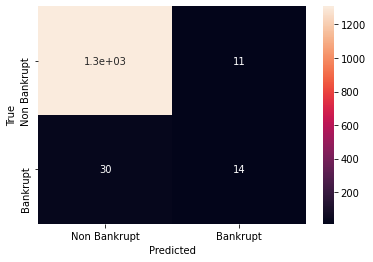

In [26]:
cv_svm_ga_model = cs_svm_ga.best_estimator_
models_dictionary = OrderedDict()
models_dictionary['SVM+GA'] = cv_svm_ga_model

# Cross validación con 5 sets
results = perform_data_modeling(models_dictionary, imputed_df, verbose=True, k_folds=5)

## Evaluation

In [27]:
def save_and_show_resultados(descripcion, model, resultados, X_train, X_test, y_train, y_test):
  y_train_pred = model.predict(X_train)
  y_train_pred_proba = model.predict_proba(X_train)[:,1]

  y_test_pred = model.predict(X_test)
  y_test_pred_proba = model.predict_proba(X_test)[:,1]

  confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
  confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

  resultados.update( { descripcion: {
      ('Entrenamiento', 'Exactitud'): model.score(X_train, y_train),
      ('Entrenamiento', 'F1'): f1_score(y_train, y_train_pred),
      ('Entrenamiento', 'AUC'): roc_auc_score(y_train, y_train_pred_proba),
      ('Entrenamiento', 'TypeI'): confusion_matrix_train[0][1],
      ('Pruebas', 'Exactitud'): model.score(X_test, y_test),
      ('Pruebas', 'F1'): f1_score(y_test, y_test_pred),
      ('Pruebas', 'AUC'): roc_auc_score(y_test, y_test_pred_proba),
      ('Pruebas', 'TypeI'): confusion_matrix_test[0][1]
    } } )
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  fig.suptitle(f'{descripcion} (Conjunto de Pruebas)')
  plot_confusion_matrix(model, X_test, y_test, ax=axes[0], values_format='d')
  plot_roc_curve(model, X_test, y_test, ax=axes[1], name=descripcion)
  plot_precision_recall_curve(model, X_test, y_test, ax=axes[2], name=descripcion)
  return

In [28]:
# hacemos la division del dataframe en variables y etiquetas
X, y = split_features(imputed_df,important_features)

# Dividimos la data en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, \
            stratify = y,test_size = 0.2,random_state=1)

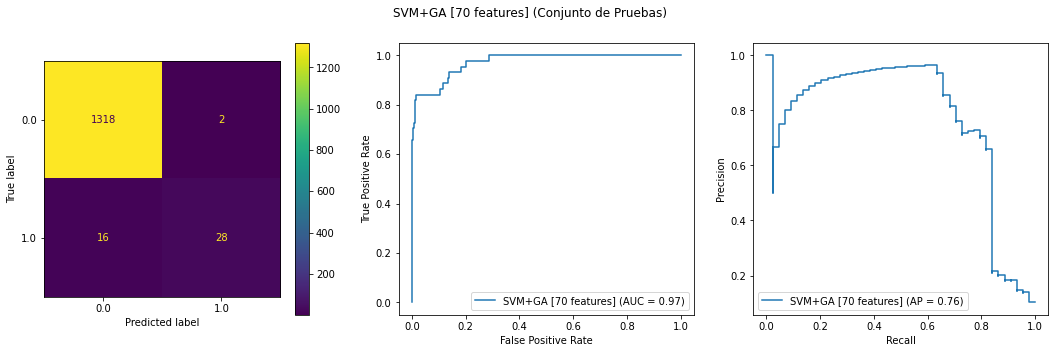

In [30]:
resultados = {}
save_and_show_resultados('SVM+GA [70 features]', cv_svm_ga_model, resultados, X_train, X_test, y_train, y_test)

In [31]:
def tabla_resultados(resultados):
  df = pd.DataFrame.from_dict(resultados, orient='index')
  display(df)
  return df
tabla_resultados(resultados)

Entrenamiento                            Pruebas  \
                         Exactitud       F1       AUC TypeI Exactitud   
SVM+GA [70 features]      0.990834  0.84375  0.978067     9  0.986804   

                                                
                            F1       AUC TypeI  
SVM+GA [70 features]  0.756757  0.971402     2

Entrenamiento                            Pruebas  \
                         Exactitud       F1       AUC TypeI Exactitud   
SVM+GA [70 features]      0.990834  0.84375  0.978067     9  0.986804   

                                                
                            F1       AUC TypeI  
SVM+GA [70 features]  0.756757  0.971402     2